# Neural Networks

This notebook will attempt to train some Neural Networks on the Training data and save it for later use

## Author: Alexander Goudemond, Student Number: 219030365

In this notebook, we are going to begin looking at training some neural networks.

After trying several UNet Tutorials, I have learnt of several problems that I have had to overcome:

- The tutorial data-sets are either not clean or not accessible (hosted on private servers or websites, like Kaggle, Medium, PyImageSearch)

- The implementation is complicated and/or built on old dependencies, meaning that modifying the architecture results in problems that are difficult to fix

- For offline training - The laptop I am using is not powerful enough, as the Graphics Card does not have enough VRAM

- The DataSet I have been using was not properly prepared for Training. One such problem was that the Masks were pixelated, as a result of being saved as JPG images early on

- The number of classes in each of my masks is not consistent - each cell seems to be allocated a unique class

Here is how I have designed the environment to circumvent these problems:

- Offline, I generate folders for Training (Images and there corresponding Masks) The images are in colour, whereas the masks are grasycale

- I upload the 2 Training folders onto Google Drive

- I use UNet architectures that seemed to work in the past. One is a pretrained model, which I retrain and the other uses Patchify to crop and slice the images into smaller pieces

In this notebook, we explore training the Pre-Trained Model from the Tensorflow website on 1 DataSet, and make us of the patchify tutorial from Dr. Sreenivas Bhattiprolu.

Tensorflow link:

https://www.tensorflow.org/tutorials/images/segmentation 

Dr. Sreenivas Bhattiprolu:

https://github.com/bnsreenu/python_for_microscopists/tree/master/228_semantic_segmentation_of_aerial_imagery_using_unet

# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Please ensure the following folders exist

drive > MyDrive > COMP700_Images > COMP700_Processed_Training_GT

drive > MyDrive > COMP700_Images > COMP700_Processed_Training_ST

drive > MyDrive > COMP700_Images > COMP700_Raw_Training_GT

drive > MyDrive > COMP700_Images > COMP700_Raw_Training_ST

drive > MyDrive > COMP700_Neural_Network_Code

The latter location is where the Jupyter Notebooks will be loaded, and the former directories will contain the images used. These images are generated offline by the other notebooks and then uploaded to Google Drive

# Installs

In [ ]:
!pip install patchify
!pip install segmentation-models
!pip install git+https://github.com/tensorflow/examples.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-vxyflsok
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-vxyflsok


# Imports

In [ ]:
from os import getcwd, walk, mkdir, stat, remove
from os import sep # used later on, in a function, to print directory contents
from os.path import exists, basename, join

from shutil import copyfile

from PIL.Image import fromarray
import cv2

import matplotlib.pyplot as plt
import numpy as np

from patchify import patchify

import segmentation_models as sm

import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
from tensorflow import keras
from keras.layers import Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate, Input, Lambda
from tensorflow.keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from IPython.display import clear_output


Segmentation Models: using `keras` framework.


# Verify that files exist

We will be going to our training data and fetching 1 folder for our x and y training variables. Once that is successful, we will explore training on each of the datasets together

In [ ]:
getcwd()

'/content'

Let's do a sanity check before continuing:

In [ ]:
google_drive_path = "/drive/MyDrive"
training_data_folder = "COMP700_Processed_Training_GT"
training_data_directory = getcwd() + google_drive_path + "/COMP700_Images/"

In [ ]:
training_data_directory

'/content/drive/MyDrive/COMP700_Images/'

In [ ]:
# "COMP700_Processed_Training_ST"
x_dirs = []
y_dirs = []
x_length = []
y_length = []

for root, dirs, files in walk(training_data_directory + "COMP700_Processed_Training_ST"):
    # print(dirs)
    if ("X" in dirs or "Y" in dirs):
        # print("yes", root)
        for root2, dirs2, files2 in walk(root + "/X"):
            x_dirs.append(root2[-20 : ])
            x_length.append(len(files2))

        for root2, dirs2, files2 in walk(root + "/Y"):
            y_dirs.append(root2[-20 : -5])
            y_length.append(len(files2))

In [ ]:
print(x_length)
print(y_length)
print()
#uncomment if sizes dont match, and find problem dataset
# print(x_dirs)
# print(y_dirs)


[115, 115, 84, 84, 92, 97, 300, 300, 92, 92, 1764, 1764, 1378, 1386, 48, 48]
[115, 115, 84, 84, 92, 92, 300, 300, 92, 92, 1764, 1764, 1376, 1386, 48, 48]



In [ ]:
# "COMP700_Processed_Training_GT"
x_dirs = []
y_dirs = []
x_length = []
y_length = []

for root, dirs, files in walk(training_data_directory + "COMP700_Processed_Training_GT"):
    # print(dirs)
    if ("X" in dirs or "Y" in dirs):
        # print("yes", root)
        for root2, dirs2, files2 in walk(root + "/X"):
            x_dirs.append(root2[-20 : ])
            x_length.append(len(files2))

        for root2, dirs2, files2 in walk(root + "/Y"):
            y_dirs.append(root2[-20 : -5])
            y_length.append(len(files2))


In [ ]:
print(x_length)
print(y_length)
print()
#uncomment if sizes dont match, and find problem dataset
# print(x_dirs)
# print(y_dirs)


[]
[]



# Load image paths variables

We know that each directory contains 2 folders: X and Y, and we want the one with the largest number of DataSets

In [ ]:
google_drive_path = "/drive/MyDrive"
training_data_folder = "COMP700_Processed_Training_ST"
training_data_directory = getcwd() + google_drive_path + "/COMP700_Images/" + training_data_folder
desired_directory = ""

maxLength = -1
length = 0

# look for largest length
for root, dirs, files in walk(training_data_directory):
    if (len(files) > 0):
        length = len(files)

        if (maxLength < length):
            desired_directory = root
            maxLength = length

print(desired_directory, "length:", maxLength)




/content/drive/MyDrive/COMP700_Images/COMP700_Training_ST/BF-C2DL-HSC/BF-C2DL-HSC/01/Y length: 1764


Let's remove the X and prepare the data for training:

In [ ]:
desired_directory = desired_directory[ : -2]

desired_directory

'/content/drive/MyDrive/COMP700_Images/COMP700_Training_ST/BF-C2DL-HSC/BF-C2DL-HSC/01'

In [ ]:
x_training_paths = []
y_training_paths = []

# should only execute twice
for root, dirs, files in walk(desired_directory):
    if ("X" in root):
        x_training_paths = files # entire array loaded
    elif ("Y" in root):
        y_training_paths = files # entire array loaded

print("Length of X Training:", len(x_training_paths))
print("Length of Y Training:", len(y_training_paths))

# update the paths:

for i in range(len(x_training_paths)):
    x_training_paths[i] = desired_directory + "/X/" + x_training_paths[i]
    y_training_paths[i] = desired_directory + "/Y/" + y_training_paths[i]

Length of X Training: 1764
Length of Y Training: 1764


What do the paths look like?

In [ ]:
x_training_paths[0:10]

['/content/drive/MyDrive/COMP700_Images/COMP700_Training_ST/BF-C2DL-HSC/BF-C2DL-HSC/01/X/processed1_t0561.tif',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_ST/BF-C2DL-HSC/BF-C2DL-HSC/01/X/processed1_t0604.tif',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_ST/BF-C2DL-HSC/BF-C2DL-HSC/01/X/processed1_t0915.tif',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_ST/BF-C2DL-HSC/BF-C2DL-HSC/01/X/processed1_t0840.tif',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_ST/BF-C2DL-HSC/BF-C2DL-HSC/01/X/processed1_t0623.tif',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_ST/BF-C2DL-HSC/BF-C2DL-HSC/01/X/processed1_t0924.tif',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_ST/BF-C2DL-HSC/BF-C2DL-HSC/01/X/processed1_t0752.tif',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_ST/BF-C2DL-HSC/BF-C2DL-HSC/01/X/processed1_t0680.tif',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_ST/BF-C2DL-HSC/BF-C2DL-HSC/01/X/processed1_t062

In [ ]:
y_training_paths[0:10]

['/content/drive/MyDrive/COMP700_Images/COMP700_Training_ST/BF-C2DL-HSC/BF-C2DL-HSC/01/Y/man_seg0705.png',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_ST/BF-C2DL-HSC/BF-C2DL-HSC/01/Y/man_seg0762.png',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_ST/BF-C2DL-HSC/BF-C2DL-HSC/01/Y/man_seg0627.png',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_ST/BF-C2DL-HSC/BF-C2DL-HSC/01/Y/man_seg1185.png',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_ST/BF-C2DL-HSC/BF-C2DL-HSC/01/Y/man_seg0887.png',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_ST/BF-C2DL-HSC/BF-C2DL-HSC/01/Y/man_seg1204.png',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_ST/BF-C2DL-HSC/BF-C2DL-HSC/01/Y/man_seg1152.png',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_ST/BF-C2DL-HSC/BF-C2DL-HSC/01/Y/man_seg0679.png',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_ST/BF-C2DL-HSC/BF-C2DL-HSC/01/Y/man_seg0849.png',
 '/content/drive/MyDrive/COMP700_Imag

We recognize that the images do not correspond, this is because Drive may save them via a HashMap. Let us sort them and re-look:

In [ ]:
x_training_paths.sort()
y_training_paths.sort()

In [ ]:
x_training_paths[0:10]

['/content/drive/MyDrive/COMP700_Images/COMP700_Training_ST/BF-C2DL-HSC/BF-C2DL-HSC/01/X/processed1_t0000.tif',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_ST/BF-C2DL-HSC/BF-C2DL-HSC/01/X/processed1_t0001.tif',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_ST/BF-C2DL-HSC/BF-C2DL-HSC/01/X/processed1_t0002.tif',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_ST/BF-C2DL-HSC/BF-C2DL-HSC/01/X/processed1_t0003.tif',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_ST/BF-C2DL-HSC/BF-C2DL-HSC/01/X/processed1_t0004.tif',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_ST/BF-C2DL-HSC/BF-C2DL-HSC/01/X/processed1_t0005.tif',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_ST/BF-C2DL-HSC/BF-C2DL-HSC/01/X/processed1_t0006.tif',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_ST/BF-C2DL-HSC/BF-C2DL-HSC/01/X/processed1_t0007.tif',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_ST/BF-C2DL-HSC/BF-C2DL-HSC/01/X/processed1_t000

In [ ]:
y_training_paths[0:10]

['/content/drive/MyDrive/COMP700_Images/COMP700_Training_ST/BF-C2DL-HSC/BF-C2DL-HSC/01/Y/man_seg0000.png',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_ST/BF-C2DL-HSC/BF-C2DL-HSC/01/Y/man_seg0001.png',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_ST/BF-C2DL-HSC/BF-C2DL-HSC/01/Y/man_seg0002.png',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_ST/BF-C2DL-HSC/BF-C2DL-HSC/01/Y/man_seg0003.png',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_ST/BF-C2DL-HSC/BF-C2DL-HSC/01/Y/man_seg0004.png',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_ST/BF-C2DL-HSC/BF-C2DL-HSC/01/Y/man_seg0005.png',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_ST/BF-C2DL-HSC/BF-C2DL-HSC/01/Y/man_seg0006.png',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_ST/BF-C2DL-HSC/BF-C2DL-HSC/01/Y/man_seg0007.png',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_ST/BF-C2DL-HSC/BF-C2DL-HSC/01/Y/man_seg0008.png',
 '/content/drive/MyDrive/COMP700_Imag

# View sample Image and Masks - before and after resizing

Let us see the images together, before and after resizing:

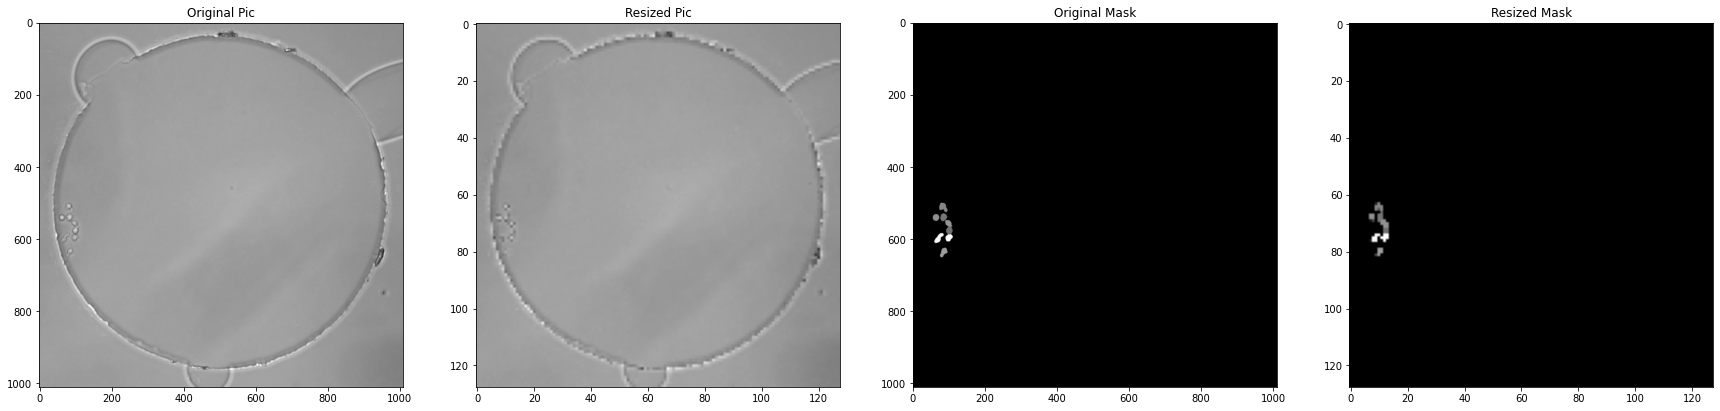

In [ ]:
# Let's now try show these images side by side to verify results:

from random import randint

# 1604 is a good recurring example
index = randint(0, len(x_training_paths) - 1)
dim = (224, 224)

fig = plt.figure(figsize=(30,8))

plt.subplot(1, 4, 1)
original_pic = img = cv2.imread( x_training_paths[index] )
plt.imshow(original_pic)
plt.title("Original Pic")

plt.subplot(1, 4, 2)
resized_pic = cv2.resize( cv2.imread( x_training_paths[index] ) , dim)
plt.imshow(resized_pic)
plt.title("Resized Pic")

plt.subplot(1, 4, 3)
original_mask = cv2.imread( y_training_paths[index] , cv2.IMREAD_GRAYSCALE)
plt.imshow(original_mask, cmap="gray")
plt.title("Original Mask")

plt.subplot(1, 4, 4)
resized_mask = cv2.resize( cv2.imread( y_training_paths[index], cv2.IMREAD_GRAYSCALE) , dim)
plt.imshow(resized_mask, cmap="gray")
plt.title("Resized Mask")

plt.show()

let us also check the number of distinct pixels in those images:


In [ ]:
print("Distinct Pixels in Original Pic:",  len(np.unique( original_pic  )))
print("Distinct Pixels in Resized Pic:",   len(np.unique( resized_pic   )))
print("Distinct Pixels in Oringal Mask:",  len(np.unique( original_mask )))
print("Distinct Pixels in Resized Mask:",  len(np.unique( resized_mask  )))

Distinct Pixels in Original Pic: 217
Distinct Pixels in Resized Pic: 138
Distinct Pixels in Oringal Mask: 9
Distinct Pixels in Resized Mask: 20


Visually, we can see that we are losing quality by resizing the image. Our mask also has an increase in the number of classes

So, we will not resize, and instead use Patchify to cut the images into more manageable pieces

The cropped images will be generated next in the notebook, thereafter we can train the models. 

# Partition Training Data

Our data is going to become smaller, so we can shuffle and split the information before selecting a smaller pool of information:

In [ ]:
from sklearn.model_selection import train_test_split

x_train_paths, x_test_paths, \
y_train_paths, y_test_paths = train_test_split(
                                              x_training_paths, 
                                              y_training_paths, 
                                              test_size=0.2, 
                                              random_state=4
                                              )


In [ ]:
print(len(x_train_paths))
print(len(y_train_paths))
print(len(x_test_paths))
print(len(y_test_paths))

1411
1411
353
353


Let's take the 10% of those values for our model, as Patchify will stretch the data into more images

In [ ]:
partition_x = (int) (0.1 * len(x_train_paths) )

partition_x

141

In [ ]:
x_reduced_train_paths = x_train_paths[ 0 : partition_x]
y_reduced_train_paths = y_train_paths[ 0 : partition_x]

In [ ]:
print(len(x_reduced_train_paths))
print(len(y_reduced_train_paths))

141
141


# Crop and Patchify images

Let's declare our scaler and patch size

In [ ]:
scaler = MinMaxScaler()
patch_size = 224

Now, we need to go through each of the images in x_image_paths and patchify them

In [ ]:
def extractRHS(string, symbol):
    index = string.rfind(symbol)
    # print(index)
    return string[ index + 1 : ]
###

extractRHS("219030365@stu.ukzn.zc.za", "@")

'stu.ukzn.zc.za'

In [ ]:
# from PIL.Image import fromarray

#Read images from repsective 'images' subdirectory
#As all images are of ddifferent size we have 2 options, either resize or crop
#But, some images are too large and some small. Resizing will change the size of real objects.
#Therefore, we will crop them to a nearest size divisible by 256 and then 
#divide all images into patches of 256x256x3. 
# image_dataset = np.array([])  
image_dataset = []
count = -1
length = len(x_reduced_train_paths)

for path in x_reduced_train_paths:
  count += 1
  image = cv2.imread(path, 1) # read as BGR

  # print("Old Shape:", image.shape, end="; ")

  SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
  SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size

  # print(SIZE_X, ":", SIZE_Y)

  image = fromarray(image)
  image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
  #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
  image = np.array(image)

  # print("New Shape:", image.shape)

  #Extract patches from each image
  print("Now patchifying image:", extractRHS(path, "/") , "-->", count, "/", length)
  patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap

  for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
      
      single_patch_img = patches_img[i,j,:,:]
      
      #Use minmaxscaler instead of just dividing by 255. 
      single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
      
      #single_patch_img = (single_patch_img.astype('float32')) / 255. 
      single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds. 

      # img_new = (single_patch_img * 255).astype(int) # scale up values
      img_new = single_patch_img

      # image_dataset = np.append(image_dataset, img_new)
      image_dataset.append(img_new)


Now patchifying image: processed1_t1159.tif --> 0 / 141
Now patchifying image: processed1_t0908.tif --> 1 / 141
Now patchifying image: processed1_t0674.tif --> 2 / 141
Now patchifying image: processed1_t1571.tif --> 3 / 141
Now patchifying image: processed1_t0005.tif --> 4 / 141
Now patchifying image: processed1_t1127.tif --> 5 / 141
Now patchifying image: processed1_t0047.tif --> 6 / 141
Now patchifying image: processed1_t0890.tif --> 7 / 141
Now patchifying image: processed1_t0265.tif --> 8 / 141
Now patchifying image: processed1_t0405.tif --> 9 / 141
Now patchifying image: processed1_t1312.tif --> 10 / 141
Now patchifying image: processed1_t1468.tif --> 11 / 141
Now patchifying image: processed1_t1636.tif --> 12 / 141
Now patchifying image: processed1_t1528.tif --> 13 / 141
Now patchifying image: processed1_t1556.tif --> 14 / 141
Now patchifying image: processed1_t1428.tif --> 15 / 141
Now patchifying image: processed1_t0727.tif --> 16 / 141
Now patchifying image: processed1_t0289.t

In [ ]:
print("Length original images:", len(x_reduced_train_paths))
print("Length of patchified images", len(image_dataset))

Length original images: 141
Length of patchified images 2256


In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]), cmap="gray")
    plt.axis('off')
  plt.show()


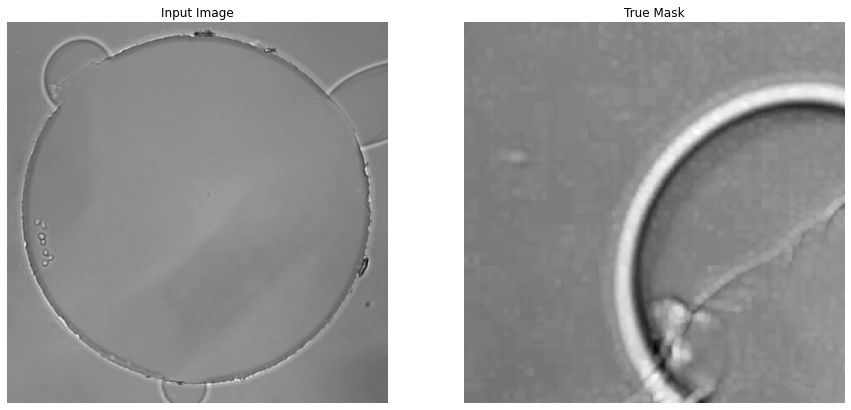

In [ ]:
array = [ cv2.imread(x_reduced_train_paths[0]), image_dataset[0]]

display(array)

As we can see from the above, our patchify images are pieces of the original!

Let us now repeat that for the masks

In [ ]:
#Read images from repsective 'images' subdirectory
#As all images are of ddifferent size we have 2 options, either resize or crop
#But, some images are too large and some small. Resizing will change the size of real objects.
#Therefore, we will crop them to a nearest size divisible by 256 and then 
#divide all images into patches of 256x256x3. 
# mask_dataset = np,array([])  
mask_dataset = []
count = -1
length = len(y_reduced_train_paths)

for path in y_reduced_train_paths:
  count += 1
  image = cv2.imread(path, 1) # read as BGR

  # print("Old Shape:", image.shape, end="; ")

  SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
  SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size

  # print(SIZE_X, ":", SIZE_Y)

  image = fromarray(image)
  image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
  #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
  image = np.array(image)

  # print("New Shape:", image.shape)

  #Extract patches from each image
  print("Now patchifying image:", extractRHS(path, "/") , "-->", count, "/", length)
  patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap

  for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
      
      single_patch_img = patches_img[i,j,:,:]
      
      #Use minmaxscaler instead of just dividing by 255. 
      single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
      
      #single_patch_img = (single_patch_img.astype('float32')) / 255. 
      single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds. 

      # img_new = (single_patch_img * 255).astype(int) # scale up values
      img_new = single_patch_img

      # np.append(mask_dataset, img_new)
      mask_dataset.append(img_new)


Now patchifying image: man_seg1159.png --> 0 / 141
Now patchifying image: man_seg0908.png --> 1 / 141
Now patchifying image: man_seg0674.png --> 2 / 141
Now patchifying image: man_seg1571.png --> 3 / 141
Now patchifying image: man_seg0005.png --> 4 / 141
Now patchifying image: man_seg1127.png --> 5 / 141
Now patchifying image: man_seg0047.png --> 6 / 141
Now patchifying image: man_seg0890.png --> 7 / 141
Now patchifying image: man_seg0265.png --> 8 / 141
Now patchifying image: man_seg0405.png --> 9 / 141
Now patchifying image: man_seg1312.png --> 10 / 141
Now patchifying image: man_seg1468.png --> 11 / 141
Now patchifying image: man_seg1636.png --> 12 / 141
Now patchifying image: man_seg1528.png --> 13 / 141
Now patchifying image: man_seg1556.png --> 14 / 141
Now patchifying image: man_seg1428.png --> 15 / 141
Now patchifying image: man_seg0727.png --> 16 / 141
Now patchifying image: man_seg0289.png --> 17 / 141
Now patchifying image: man_seg1001.png --> 18 / 141
Now patchifying image:

In [ ]:
print("Length original images:", len(y_reduced_train_paths))
print("Length of patchified images", len(mask_dataset))

Length original images: 141
Length of patchified images 2256


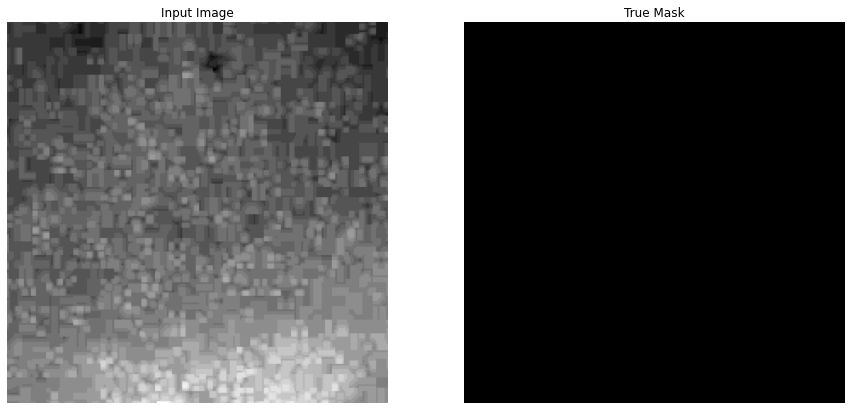

In [ ]:
position = 6
array = [ image_dataset[position], mask_dataset[position] ]

display( array )

Let us double check the unique pixels in our image:

In [ ]:
print(np.unique(image_dataset[position]))

[0.         0.05555556 0.11111111 0.16666667 0.22222222 0.27777778
 0.33333333 0.38888889 0.44444444 0.5        0.55555556 0.61111111
 0.66666667 0.72222222 0.77777778 0.83333333 0.88888889 0.94444444
 1.        ]


In [ ]:
print(np.unique(mask_dataset[position]))

[0.]


Okay! we are making progress now! Let us keep going:

In [ ]:
print(type(image_dataset[0]))
print(type(image_dataset))


<class 'numpy.ndarray'>
<class 'list'>


If we need to place a Numpy array into the model, we will convert the image_dataset and mask)dataset into Numpy Arrays

# Train and Test Data

In [ ]:
print(len(image_dataset))
print(len(mask_dataset))

2256
2256


In [ ]:
# Because we shuffled earlier, we can just select the first 90% of the data here
partition = (int) (0.9 * len(image_dataset))

x_train = image_dataset[ 0 : partition ]
y_train = mask_dataset[ 0 : partition]

x_test  = image_dataset[ partition : ]
y_test  = mask_dataset[ partition : ]

# Define Model

In [ ]:
INPUT_SIZE = patch_size

base_model = tf.keras.applications.MobileNetV2(input_shape=[INPUT_SIZE, INPUT_SIZE, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False


In [ ]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]


In [ ]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[INPUT_SIZE, INPUT_SIZE, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)


In [ ]:
random_index = randint(0, len(y_train)-1)

sample_image, sample_mask = x_train[random_index], y_train[random_index]

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]


In [ ]:
# def display(display_list):
#   plt.figure(figsize=(15, 15))

#   title = ['Input Image', 'True Mask', 'Predicted Mask']

#   for i in range(len(display_list)):
#     plt.subplot(1, len(display_list), i+1)
#     plt.title(title[i])
#     plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
#     plt.axis('off')
#   plt.show()


In [ ]:
def show_predictions(model, dataset=None):
  if dataset:
    for image, mask in dataset:
      pred_mask = model.predict(image[tf.newaxis, ...])
      display([image, mask, create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])


# Create and Train the Model

In [ ]:
OUTPUT_CLASSES = 3 # notice output classes
tensorflow_model = unet_model(output_channels=OUTPUT_CLASSES)

# RMSprop compiler
tensorflow_model.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
tensorflow_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             [(None, 112, 112, 9  1841984     ['input_2[0][0]']                
                                6),                                                               
                                 (None, 56, 56, 144                                               
                                ),                                                                
                                 (None, 28, 28, 192                                         

1/1 [==============================] - 10s 10s/step


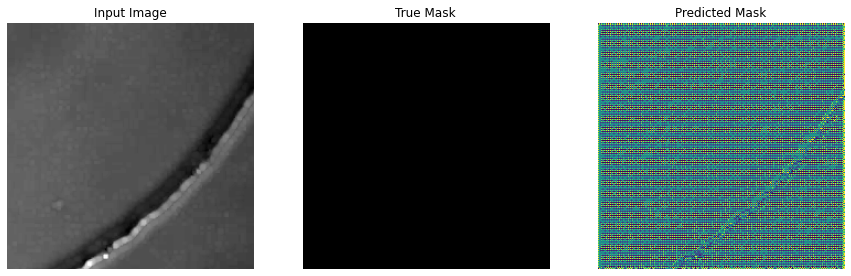

In [ ]:
# predict before training to see what happens
show_predictions(tensorflow_model)

In [ ]:
print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))

2030
2030
226
226


Just a simple check incase our training data is too large:

In [ ]:
threshold = 200
if (len(x_train) > threshold):
  x_train = x_train[ 0 : threshold]
  y_train = y_train[ 0 : threshold]

In [ ]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [ ]:
len(y_train)

200

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions(tensorflow_model)
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))
  
class LearningRateReducerCb(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    old_lr = self.model.optimizer.lr.read_value()
    new_lr = old_lr * 0.99
    print("\nEpoch: {}. Reducing Learning Rate from {} to {}".format(epoch, old_lr, new_lr))
    self.model.optimizer.lr.assign(new_lr)


1/1 [==============================] - 0s 21ms/step


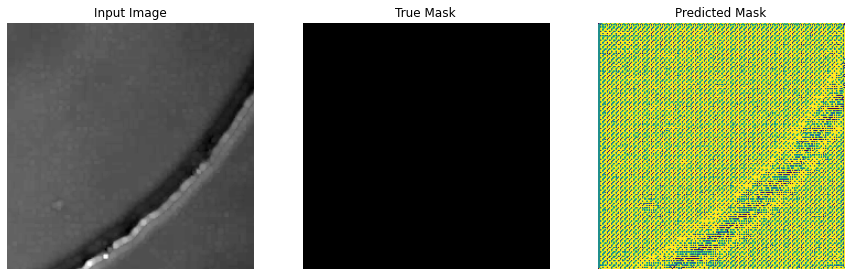


Sample Prediction after epoch 20


Epoch: 19. Reducing Learning Rate from 0.000826168863568455 to 0.000817907159216702
100/100 [==============================] - 2s 22ms/step - loss: 0.0043 - accuracy: 0.1663


In [ ]:
# Training Below

TRAIN_LENGTH = len(x_train)
BATCH_SIZE = 2
VAL_SUBSPLITS = 5

EPOCHS = 20
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VALIDATION_STEPS = STEPS_PER_EPOCH // VAL_SUBSPLITS

tensorflow_model_history = tensorflow_model.fit(
                                                x_train,
                                                y_train, 
                                                epochs=EPOCHS,
                                                steps_per_epoch=STEPS_PER_EPOCH,
                                                callbacks=[DisplayCallback(), LearningRateReducerCb()],
                                                validation_steps=VALIDATION_STEPS,
                                                validation_data=(x_test, y_test)
                                                )




1/1 [==============================] - 0s 22ms/step


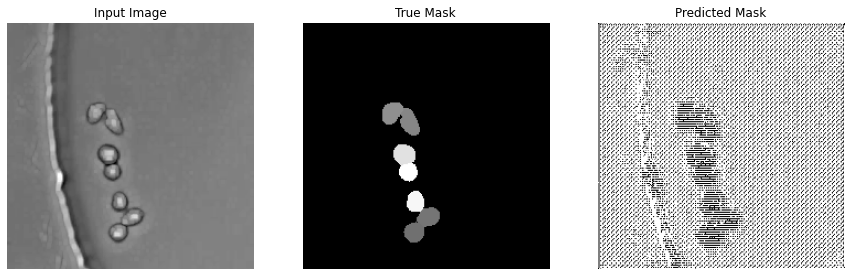

In [ ]:
# try predict something
index = 8
array = [ [ x_train[index], y_train[index] ] ]

# display(array)
show_predictions(tensorflow_model, array)

I managed to prevent the loss function starting with NaN, with the pixels being in the range [0, 1]...

Now, I have discovered another problem, whereby my dataset has too much information present.

This circular petri dish is messing up the training, so I need to try revist my processed data and see if I can improve things

In another notebook, I will need to load a different dataset and see how that classifies things!